In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

s_sz = 4
a_sz = 2

observation space: Box(4,)
action space: Discrete(2)


In [103]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class PolicyNet():
    def __init__(self, s_size, a_size, noise, noise_min, noise_max, pop_size):
        self.w = np.random.rand(s_size, a_size)*(np.sqrt(6)/np.sqrt(s_size + a_size+1))
        self.noise = noise
        self.nmin = noise_min
        self.nmax = noise_max
        self.popsize = pop_size
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return softmax(x)
    
    def act(self, state):
        probs = self.forward(state)
        action = np.random.choice(2, p=probs)
        return action
    
    def populate(self):
        population = np.array([self.w + self.noise*np.random.randn(*self.w.shape) for _ in range(self.popsize)])
        return population

In [83]:
def hill_climbing_steepest_ANS(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_Return = -np.inf
    best_w = policy.w
    noise = []
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.empty((max_t, policy.popsize))
        returns = np.empty((policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(len(policies)):
            policy.w = policies[p]
            action = policy.act(state_alpha)
            next_state, reward, done, _ = env.step(action)
            rewards[0,p] = reward
            state = next_state
            for t in range(max_t-1):
                action = policy.act(state)
                next_state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                state = next_state
                if done:
                    break
                
            discounts = [gamma**i for i in range(len(rewards)+1)]
            returns[p] = sum([r*d for r,d in zip(rewards[:,p], discounts)])
        
        best_p = np.argmax(returns)
        #top5_p = (-returns).argsort(axis=-1)[:,:5]
        if max(returns)>=best_Return:
            best_w = policies[best_p]
            policy.noise = max(policy.nmin, policy.noise*0.66)
            policy.w = best_w
            best_Return = max(returns)
        else:
            policy.noise = min(policy.nmax, policy.noise*1.05)
            policy.w = policies[best_p]
        
        scores_deque.append(returns[best_p])
        scores.append(returns[best_p])
        noise.append(policy.noise)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            best_p = np.argmax(returns)
            best_w = policies[best_p]
            policy.w = best_w
            break
        
    return scores, noise
            

In [104]:
policy_net = PolicyNet(s_sz, a_sz, noise=1e-3, noise_min=1e-3, noise_max=2, pop_size=10)
scores, search_r = hill_climbing_steepest_ANS(policy_net, n_episodes=2500)

Episode 100	Average Score: 18.93
Episode 200	Average Score: 28.23
Episode 300	Average Score: 30.35
Episode 400	Average Score: 33.68
Episode 500	Average Score: 38.16
Episode 600	Average Score: 26.16
Episode 700	Average Score: 43.29
Episode 800	Average Score: 47.65
Episode 900	Average Score: 40.07


/Users/andre/opt/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/andre/opt/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: probabilities contain NaN

array([[-19.24833052, -56.00750048],
       [  3.64750564,  53.63846221],
       [ 31.62480881,   9.99151476],
       [-52.20758413, -68.05963162]])

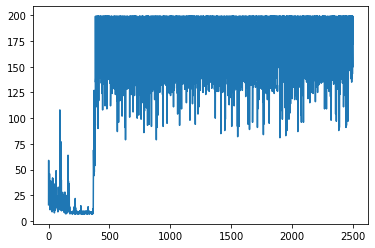

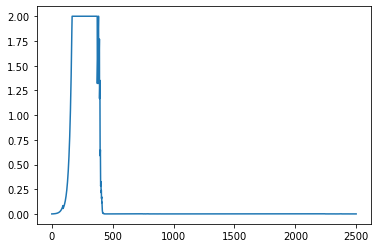

In [105]:
plt.plot(scores)
plt.figure()
plt.plot(search_r)
policy_net.w

In [97]:
arr = np.array([[10,-10,-20,30], [10, 20, 30,40]])

idx = (-arr).argsort(axis=-1)[:,:2]
arr[idx]

IndexError: index 3 is out of bounds for axis 0 with size 2

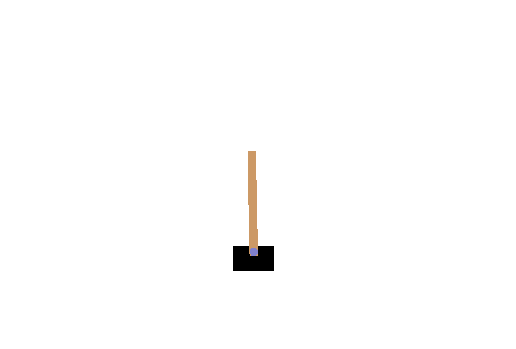

In [56]:
torender_episodes = 3
torender_frames = 100

plt.figure(figsize=(9,9))

for i in range(0,torender_episodes):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(torender_frames):
        action = policy_net.act(state)
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 

env.close()

In [33]:
policy_net.w

array([[  8.54767211,  19.19565465],
       [  5.17799449, -50.31955651],
       [-21.60676498,  -3.69386024],
       [-58.30734865,   7.71101306]])

In [34]:
np.random.rand(4, 2)

array([[0.16979408, 0.59818766],
       [0.1999142 , 0.73073565],
       [0.60684317, 0.57794965],
       [0.80304107, 0.3211556 ]])

In [ ]:
softmax